In [5]:
# import packages 
import sys

sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
#from helperToolz.feevos.rocksdbutils_copy import *

In [6]:
db_name = 'AI4_RGB_exclude_True'

aa  = RocksDBDataset(f'/data/fields/output/rocks_db/{db_name}.db/train.db', transform=None)
bb  = RocksDBDataset(f'/data/fields/output/rocks_db/{db_name}.db/valid.db', transform=None)


In [12]:
def getFilelist(originpath, ftyp, deep = False, order = True):
    out   = []
    if deep == False:
        files = os.listdir(originpath)
        for i in files:
            if i.split('.')[-1] in ftyp:
                if originpath.endswith('/'):
                    out.append(originpath + i)
                else:
                    out.append(originpath + '/' + i)
            # else:
            #     print("non-matching file - {} - found".format(i.split('.')[-1]))
    else:
        for path, subdirs, files in os.walk(originpath):
            for i in files:
                if i.split('.')[-1] in ftyp:
                    out.append(os.path.join(path, i))
    if order == True:
        out = sorted(out)
    return out

In [13]:

train = aa.length
valid = bb.length
nc_len = len(getFilelist('/data/fields/ai4boundaries/sentinel2/images/', '.nc', deep=True))


print(f'Training chips: {train}\nValidation chips: {valid}\nRatio: {train/(train+valid)}\nRatio_chipped:{(train+valid)/nc_len}')

Training chips: 44460
Validation chips: 14820
Ratio: 0.75
Ratio_chipped:7.569914442599924


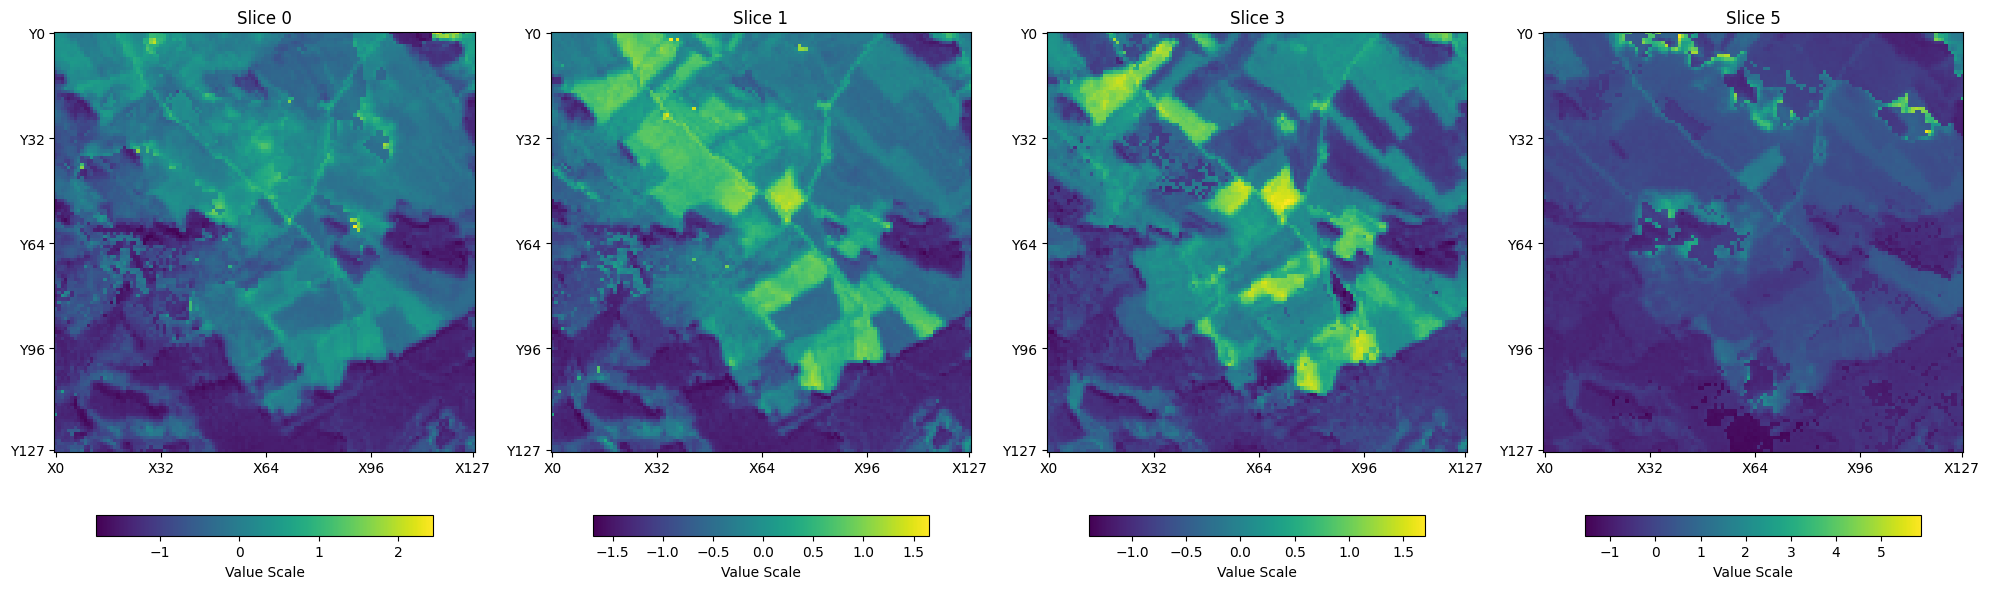

In [64]:
plotter(aa[0][0][1,:,:])

In [ ]:
db_name = 'AI4_RGB_exclude_True'
cc = RocksDBDataset(f'/data/fields/output/rocks_db/{db_name}.db/valid.db', transform=None)

In [10]:
def subset_mask_to_prediction_extent(path_reference_mask, path_to_prediction_vrt):
    '''
    path_reference_mask: path to the reference mask
    path_to_prediction_vrt: path to a vrt of the predicted image chips
    '''

    # check if mask has different extent from prediction
    # if so, make it the same extent for further processing (classification)
    # --> mask can never be smaller than prediciton, therefore no need to check

    ext_mask = getExtentRas(path_reference_mask)
    ext_pred = getExtentRas(path_to_prediction_vrt)

    if ext_mask == ext_pred:
        print('Mask already has same extent as prediction - no further subsetting needed :)')
    else:
        common_bounds = commonBoundsDim([ext_mask, ext_pred])
        common_coords = commonBoundsCoord(common_bounds)
        if common_bounds == ext_pred:
            ds = gdal.Open(path_reference_mask)
            in_gt = ds.GetGeoTransform()
            inv_gt = gdal.InvGeoTransform(in_gt)
            # transform coordinates into offsets (in cells) and make them integer
            off_UpperLeft = gdal.ApplyGeoTransform(inv_gt, common_coords[0]['UpperLeftXY'][0], common_coords[0]['UpperLeftXY'][1])  # new UL * rastersize^-1  + original ul/rastersize(opposite sign
            off_LowerRight = gdal.ApplyGeoTransform(inv_gt, common_coords[0]['LowerRightXY'][0], common_coords[0]['LowerRightXY'][1])
            off_ULx, off_ULy = map(round, off_UpperLeft) 
            off_LRx, off_LRy = map(round, off_LowerRight)

            band = ds.GetRasterBand(1)
            data = band.ReadAsArray(off_ULx, off_ULy, off_LRx - off_ULx, off_LRy - off_ULy)


            out_ds = gdal.GetDriverByName('GTiff').Create(path_reference_mask.split('.')[0] + '_prediction_extent.tif', 
                                                        off_LRx - off_ULx, 
                                                        off_LRy - off_ULy, 1, ds.GetRasterBand(1).DataType)
            out_gt = list(in_gt)
            out_gt[0], out_gt[3] = gdal.ApplyGeoTransform(in_gt, off_ULx, off_ULy)
            out_ds.SetGeoTransform(out_gt)
            out_ds.SetProjection(ds.GetProjection())

            out_ds.GetRasterBand(1).WriteArray(data)
            if band.GetNoDataValue():
                out_ds.GetRasterBand(1).SetNoDataValue(band.GetNoDataValue())
            del out_ds


chipsize = 128*2 # 5 is the maximum with GPU in basement
overlap  = 20

# make a subset of the reference mask (extent FORCE output) to the extent of the prediction
subset_mask_to_prediction_extent('/data/Aldhani/eoagritwin/fields/IACS/4_Crop_mask/GSA-DE_BRB-2019_cropMask_lines_touch_false_lines_touch_false_linecrop.tif', 
                                 f'/data/Aldhani/eoagritwin/fields/output/predictions/FORCE/BRANDENBURG/vrt/{chipsize}_{overlap}_chips.vrt')

subset_mask_to_prediction_extent('/data/Aldhani/eoagritwin/fields/IACS/4_Crop_mask/GSA-DE_BRB-2019_cropMask_lines_touch_true_lines_touch_true_linecrop.tif', 
                                 f'/data/Aldhani/eoagritwin/fields/output/predictions/FORCE/BRANDENBURG/vrt/{chipsize}_{overlap}_chips.vrt')

In [2]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *


####################################################### Prepare

# make vrts from force outputs for easier processing
year = 2023
list_of_forcefiles = reduce_force_to_validmonths(f'/data/force/output/BRANDENBURG/{year}/', 3, 8)
ordered_forcetiles = force_order_BGRBNR(list_of_forcefiles)
vrt_out_path = f'/data/fields/Auxiliary/vrt/{year}/'

In [3]:

force_folder_name = get_forcetiles_range(list_of_forcefiles)
if not vrt_out_path.endswith('/'):
    vrt_out_path = vrt_out_path + '/'
outDir = f'{vrt_out_path}{force_folder_name}/'


In [4]:
len(ordered_forcetiles)

53

In [8]:
os.makedirs(outDir)
print(outDir)
for i in range(len(ordered_forcetiles[0])):
    vrt = gdal.BuildVRT(f'{outDir}{force_folder_name}_{str(i)}.vrt', [tilefile[i] for tilefile in ordered_forcetiles], separate = False)
    vrt = None
print('single vrts created')



/data/fields/Auxiliary/vrt/2023/Force_X_from_64_to_73_Y_from_39_to_47/


single vrts created


In [9]:
# make paths in vrts relative
vrts = getFilelist(outDir, '.vrt')
for vrt in vrts:
    convertVRTpathsTOrelative(vrt)
nums = [int(vrt.split('_')[-1].split('.')[0]) for vrt in vrts]
vrts_sorted = sortListwithOtherlist(nums, vrts)[-1]
print('paths in vrts made relative')

vrt = gdal.BuildVRT(f'{outDir}{force_folder_name}_Cube.vrt', vrts_sorted, separate = True)
vrt = None
# convertVRTpathsTOrelative(f'{outDir}{force_folder_name}_Cube.vrt')
print('overlord vrt created')

vrtPyramids(f'{outDir}{force_folder_name}_Cube.vrt')
print('VRT created with pyramids')

print('Vrt might already exist - please check!!')

paths in vrts made relative
overlord vrt created
VRT created with pyramids
Vrt might already exist - please check!!
